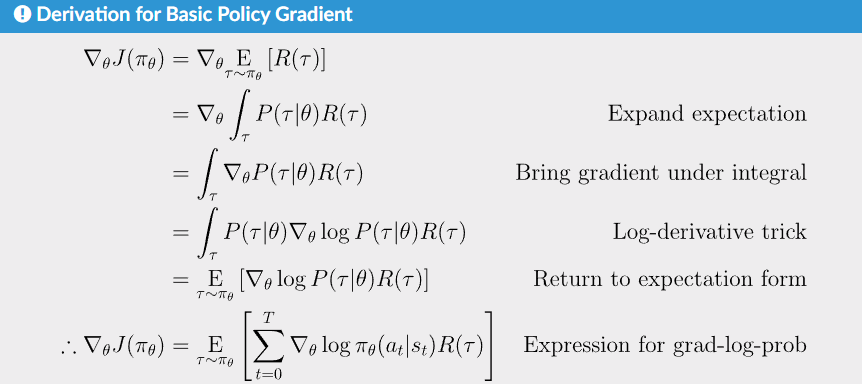

In [44]:
import numpy as np
import torch
from cartpole import CartPoleEnv
from torch import nn


In [45]:
device = (
    'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
)
print(f'Using {device} device')

Using cuda device


In [46]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_size: int, action_size: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size),
            nn.Softmax(dim=-1),
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.layers(state)

In [47]:
def choose_action(state: np.ndarray, policy_network: PolicyNetwork) -> tuple[int, torch.Tensor]:
    state = torch.from_numpy(state).float().to(device)
    action_prob = policy_network(state)
    action = torch.multinomial(action_prob, 1)
    return action.item(), action_prob

In [48]:
train_env = CartPoleEnv(render_mode='rbg_array')
test_env = CartPoleEnv(render_mode='human')
state_size = train_env.observation_space.shape[0]
action_size = train_env.action_space.n
policy = PolicyNetwork(state_size, action_size).to(device)
optimizer = torch.optim.Adam(policy.parameters(), lr=0.005)

In [49]:
def calculate_discounted_rewards(
    rewards: list[int], discount_factor: float, normalize=True
) -> torch.Tensor:
    discounted_rewards = []
    discounted_reward = 0
    for reward in reversed(rewards):
        discounted_reward = reward + discount_factor * discounted_reward
        discounted_rewards.insert(0, discounted_reward)

    discounted_rewards = torch.tensor(discounted_rewards).to(device)
    if normalize:
        discounted_rewards = (
            discounted_rewards - discounted_rewards.mean()
        ) / discounted_rewards.std()

    return discounted_rewards

In [50]:
def update_policy(
    discounted_rewards: torch.Tensor,
    optimizer: torch.optim.Optimizer,
    log_prob_actions: list[torch.Tensor],
) -> float:
    discounted_rewards = discounted_rewards.detach()
    loss = -(discounted_rewards * log_prob_actions).sum()
    optimizer.zero_grad()
    # calculated the gradient of the loss w.r.t. the policy network parameters. stored in .grad attributes of the parameters
    loss.backward()
    optimizer.step()

    return loss.item()

In [51]:
def train_one_episode(
    env: CartPoleEnv, policy: PolicyNetwork, optimizer: torch.optim.Optimizer, discount_factor=0.99
) -> tuple[int, float]:
    policy.train()
    log_prob_actions = []
    rewards = []
    episode_reward = 0
    state = env.reset()[0]
    terminated = False
    truncated = False
    while not terminated and not truncated:
        action, action_prob = choose_action(state, policy)
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state

        log_prob_actions.append(torch.log(action_prob[action]))
        rewards.append(reward)
        episode_reward += reward

    log_prob_actions = torch.stack(log_prob_actions)

    discounted_rewards = calculate_discounted_rewards(rewards, discount_factor)

    loss = update_policy(discounted_rewards, optimizer, log_prob_actions)

    return episode_reward, loss


In [52]:
def evaluate_policy(env: CartPoleEnv, policy: PolicyNetwork) -> float:
    state = env.reset()[0]
    episode_reward = 0
    terminated = False
    while not terminated:
        with torch.no_grad():
            action, _ = choose_action(state, policy)
            state, reward, terminated, truncated, info = env.step(action)

        episode_reward += reward

    return episode_reward

In [54]:
MAX_EPISODES = 1000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

train_rewards = []

for episode in range(1, MAX_EPISODES + 1):
    train_reward, loss = train_one_episode(train_env, policy, optimizer, DISCOUNT_FACTOR)

    train_rewards.append(train_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])

    if episode % PRINT_EVERY == 0:
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} |')

    if mean_train_rewards >= REWARD_THRESHOLD:
        print(f'Reached reward threshold in {episode} episodes')
        break

Reached reward threshold in 2 episodes


In [55]:
test_rewards = [evaluate_policy(test_env, policy) for _ in range(N_TRIALS)]

KeyboardInterrupt: 